# Final Project - Team 9 
### Authors: Craig Nathan, Thomas Tran, Zohaib Shahid
###### AAI 695-WS2 | Spring 2023


---

# CPE/EE/AAI 695-WS2  |  Final Project | Team 9
# Game Recommendations on Steam
### Authors: Craig Nathan, Thomas Tran, Zohaib Shahid

Steam is a video game digital distriburtion service and storefront where users can purchase and play games. The purpose of this project is to construct a Recommender System (RS) to predict the top-k unplayed games for a user based user history, users with similar tastes in genres, and games with similar genres to those the user likes.

We use a [dataset from Kaggle](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam). The dataset consists of three CSV files. This includes a file titled ‘Games’ contains titles of games and purchasable game content, ratings, price in USD, and release dates, a ‘Users’ CSV containing information regarding the users who have reviewed the games in the ‘Games’ CSV, and a ‘Recommendations’ CSV, which offers whether a user recommends the product they reviewed. Note that personal user information is not accessible within the files.

In this project we will use collaborative filtering to make recommendations. There are two types of collaborative filtering, user-based and item-based, which differ in how they compute similarities and make recommendations:

User-based collaborative filtering focuses on the relationships between users. It identifies users who are similar to the target user based on their past interactions with items (e.g., ratings, purchase history). Recommendations for the target user are generated by considering the preferences of similar users. In other words, it recommends items that were liked by users who have similar taste as the target user.

Item-based collaborative filtering focuses on the relationships between items. It computes similarities between items based on user interactions with them, such as ratings or purchase history. Recommendations for a target user are generated by identifying items that are similar to those the user has liked or interacted with in the past. In other words, it recommends items that are similar to those the target user has already liked.

In summary, user-based collaborative filtering focuses on finding similar users to the target user and recommends items based on the preferences of those similar users, while item-based collaborative filtering focuses on finding similar items to those the target user has liked and recommends items based on these similarities.

After exploring the data, we identify several challenges and methods we can use to overcome them, increasing the scope of the project significantly.

## Set Up Environment

In [ ]:
import sys
import os
import IPython
import psutil
import subprocess

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.optimize import minimize
from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, LeavePOut, ParameterGrid
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, roc_auc_score, precision_recall_curve
from sklearn.neighbors import NearestNeighbors

from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import GridSearchCV, PredefinedKFold

from collections import defaultdict

In [ ]:
# Set the project directory correctly for colab and jupyter environments
try:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_DIR = '/content/drive/MyDrive/AAI-695/Final-Project/' # Google Drive project directory
except ImportError:
    PROJECT_DIR = os.getcwd() # Jupyter Notebook project directory

# Set filename and path variables (used to save notebook fuctions into .py file for other notebooks to access - last step)
NOTEBOOK_NAME = "user_based_collaborative_filter"
NOTEBOOK_PATH = os.path.join(PROJECT_DIR, NOTEBOOK_NAME + '.ipynb')
FUNCTIONS_DIR = os.path.join(PROJECT_DIR, 'functions/')
DATA_DIR =      os.path.join(PROJECT_DIR, 'data/')

# Add the Functions module directory to the Python path
sys.path.append(FUNCTIONS_DIR)

In [ ]:
# Import functions file (ignore pylance warning)
import utility_funcs as util
import data_preprocessing_funcs as fn

# Note: Any changes to imported function files requires Runtime Restart

## Load Data

In [ ]:
steam_data = fn.load_data(DATA_DIR)

## Preprocess Data

__Important:__ After preprocessing, we want to differentiate between not rated and a negative rating (False), so first we map the boolean values to a different scale, i.e. as {-1, 1} for {False, True}, respectively. This way, the False ratings will be captured and considered in the sparse matrix.

In [ ]:
# Heavy filtering
steam_data_filt = fn.preprocess_data(steam_data, thresh=[60000, 100, 5, 1], verbose=False, plot=False)
df_games_filt, df_users_filt, df_recs_filt = fn.unpack_dict(steam_data_filt)

# Light filtering followed by a random sampling of 20% of remaining data after filtering
steam_data_filt_rnd = fn.preprocess_data(steam_data, thresh=[1, 1, 10, .2], verbose=True, plot=False)
df_games_filt_rnd, df_users_filt_rnd, df_recs_filt_rnd = fn.unpack_dict(steam_data_filt_rnd)

# steam_data_filt = fn.preprocess_data(steam_data, thresh=[60000, 100, 5, 1], verbose=True, plot=False)
# # steam_data_filt = fn.preprocess_data(steam_data, thresh=[1, 1, 2, .005], verbose=True, plot=False)
# df_games_filt, df_users_filt, df_recs_filt = fn.unpack_dict(steam_data_filt)

#####################
####  FILTERING  ####
#####################

Filter 1: Keep Reviews from Users with more than 0 hours of playtime

Games remaining (%):	 100.00%
Users remaining (%):	 99.99%
Reviews remaining (%):	 99.98%

User-Item Matrix Density (%): 0.251%

Filter 2: Keep Reviews from Users with more than 0 Games

Games remaining (%):	 100.00%
Users remaining (%):	 98.66%
Reviews remaining (%):	 99.28%

User-Item Matrix Density (%): 0.2524%

Filter 3: Keep Reviews for Games with more than 1 reviews

Games remaining (%):	 100.00%
Users remaining (%):	 98.66%
Reviews remaining (%):	 99.28%

User-Item Matrix Density (%): 0.2524%

Minimum number of reviews per game: 1

Filter 4: Keep Reviews from Users with more than 1 games

Games remaining (%):	 100.00%
Users remaining (%):	 98.66%
Reviews remaining (%):	 99.28%

User-Item Matrix Density (%): 0.2524%

Minimum number of games per user: 2

Filter: Keep Reviews from Users with more than 10 Reviews

Games remaining (%):	 100.00%
User

In [ ]:
print("Heavy Filtering:\n")
fn.estimate_memory_consumption(steam_data_filt, test_size=0.2, rating_metric='is_recommended', verbose=True)

print("\n\nLight Filtering with Random Sample:\n")
fn.estimate_memory_consumption(steam_data_filt_rnd, test_size=0.2, rating_metric='is_recommended', verbose=True)
# fn.estimate_memory_consumption(steam_data_filt, test_size=0.2, rating_metric='is_recommended', verbose=True)

Heavy Filtering:

###############################
####  MEMORY REQUIREMENTS  ####
###############################

Estimated Memory Consumption for Training Set (80.0%):
User-Item Matrix: (11043, 23) => 253989 total cells => 0.0002 GB
User-User Matrix: (11043, 11043) => 121947849 total cells => 0.1136 GB
Item-Item Matrix: (23, 23) => 529 total cells => 0.0000 GB


Light Filtering with Random Sample:

###############################
####  MEMORY REQUIREMENTS  ####
###############################

Estimated Memory Consumption for Training Set (80.0%):
User-Item Matrix: (10318, 558) => 5757444 total cells => 0.0054 GB
User-User Matrix: (10318, 10318) => 106461124 total cells => 0.0991 GB
Item-Item Matrix: (558, 558) => 311364 total cells => 0.0003 GB


### Create Sample Test Set
When considering how to split the data for our recommendation system project, we have several options, including:

1.   A simple 20/80 split, which randomly divides the data into training and test sets.
2.   Leave-p-out fashion split, where for every user, we randomly sample 80% of their data into the train set and 20% into the test set.
3.   Stratified split based on the number of reviews per user, which divides the data while maintaining the distribution of reviews per user in each subset.
4.   Time-based split, which sorts data by timestamp and uses older interactions for training and more recent interactions for testing.

The simple 20/80 split (option 1) is not ideal for our project, as it may not guarantee that each user is represented in both the train and test sets. If some users are only in the test set, the model may struggle to make accurate recommendations for those users, as it hasn't seen any data for them during training.

The leave-p-out fashion split (option 2) is a suitable choice because it ensures that each user is represented in both the train and test sets, which is important for evaluating the performance of our recommendation models. This approach helps the model learn from a diverse set of user-item interactions and simulates a more realistic scenario where predictions must be made for existing users with some available data.

The stratified split based on the number of reviews per user (option 3) may introduce sampling biases that could affect the model's performance. This approach could be useful in specific scenarios, such as when we are particularly interested in evaluating the model's performance for users with a specific range of reviews. However, option (2) is generally more suitable for our project.

The time-based split (option 4) is an alternative to consider, especially when dealing with time-sensitive data. By sorting the data by timestamp and using older interactions for training and more recent interactions for testing, we can simulate a real-world scenario where the recommendation system needs to make predictions for the future. However, this method requires timestamp information to be available in our dataset.

In summary, we recommend using the leave-p-out fashion split (option 2) for our project, ensuring each user has data in both the train and test sets.

Split in a leave-p-out fashion

In [ ]:
def leave_p_out_split(df_recs_filt, test_size=0.2):
    # Function to split data for a single user into train and test sets
    def split_user_data(user_data, test_size=test_size):
        if len(user_data) <= 1:
            print(f"Skipping user {user_data['user_id'].iloc[0]} because there's only one record")
            return None, None
        
        train_data, test_data = train_test_split(user_data, test_size=test_size, random_state=42)
        return train_data, test_data

    # Group data by user_id and apply the split_user_data function to each group
    # Store the resulting train and test DataFrames in separate lists
    train_dfs, test_dfs = zip(*df_recs_filt.groupby('user_id').apply(lambda x: split_user_data(x)).values)

    # Remove None values
    train_dfs = [x for x in train_dfs if x is not None]
    test_dfs = [x for x in test_dfs if x is not None]

    # Combine the train and test DataFrames from each user into their respective final DataFrames
    train_recs = pd.concat(train_dfs).reset_index(drop=True)
    test_recs = pd.concat(test_dfs).reset_index(drop=True)

    return train_recs, test_recs

train_recs, test_recs = leave_p_out_split(df_recs_filt, test_size=0.2)

In [ ]:
def leave_p_out_review_stratified_split(df_recs_filt, test_size=0.2):
    # Function to split data for a single user into train and test sets
    def split_user_data(user_data, test_size=test_size):
        if len(user_data) <= 1:
            print(f"Skipping user {user_data['user_id'].iloc[0]} because there's only one record")
            return None, None
        
        # Separate the positive and negative reviews
        positive_reviews = user_data[user_data['is_recommended'] == True]
        negative_reviews = user_data[user_data['is_recommended'] == False]
        
        # If there are not enough positive reviews, skip the user
        if len(positive_reviews) < 2:
            print(f"Skipping user {user_data['user_id'].iloc[0]} because there are not enough positive reviews")
            return None, None
            
        # Split the positive reviews
        train_positive, test_positive = train_test_split(positive_reviews, test_size=test_size, random_state=42)
        
        # If there are negative reviews, split them as well
        if len(negative_reviews) > 1:
            train_negative, test_negative = train_test_split(negative_reviews, test_size=test_size, random_state=42)
        else:
            train_negative, test_negative = negative_reviews, pd.DataFrame()
        
        # Combine the positive and negative reviews for the final train and test sets
        train_data = pd.concat([train_positive, train_negative])
        test_data = pd.concat([test_positive, test_negative])
        
        return train_data, test_data

    # Group data by user_id and apply the split_user_data function to each group
    # Store the resulting train and test DataFrames in separate lists
    train_dfs, test_dfs = zip(*df_recs_filt.groupby('user_id').apply(lambda x: split_user_data(x)).values)

    # Remove None values
    train_dfs = [x for x in train_dfs if x is not None]
    test_dfs = [x for x in test_dfs if x is not None]

    # Combine the train and test DataFrames from each user into their respective final DataFrames
    train_recs = pd.concat(train_dfs).reset_index(drop=True)
    test_recs = pd.concat(test_dfs).reset_index(drop=True)

    return train_recs, test_recs

# train_recs, test_recs = leave_p_out_review_stratified_split(df_recs_filt, test_size=0.2)


In [ ]:
# Leave p-out fashion split with both filtered datasets
train_p, test_p = leave_p_out_split(df_recs_filt, test_size=0.2)
train_pr, test_pr = leave_p_out_split(df_recs_filt_rnd, test_size=0.2)

# Leave p-out / review stratified split with both filtered datasets
train_ps, test_ps = leave_p_out_review_stratified_split(df_recs_filt, test_size=0.2)
train_psr, test_psr = leave_p_out_review_stratified_split(df_recs_filt_rnd, test_size=0.2)

Skipping user 5425 because there are not enough positive reviews
Skipping user 9048 because there are not enough positive reviews
Skipping user 10195 because there are not enough positive reviews
Skipping user 30936 because there are not enough positive reviews
Skipping user 54489 because there are not enough positive reviews
Skipping user 56000 because there are not enough positive reviews
Skipping user 85953 because there are not enough positive reviews
Skipping user 92808 because there are not enough positive reviews
Skipping user 99521 because there are not enough positive reviews
Skipping user 104820 because there are not enough positive reviews
Skipping user 118896 because there are not enough positive reviews
Skipping user 123552 because there are not enough positive reviews
Skipping user 125326 because there are not enough positive reviews
Skipping user 132129 because there are not enough positive reviews
Skipping user 154631 because there are not enough positive reviews
Skippi

Skipping user 1768159 because there are not enough positive reviews
Skipping user 1770523 because there are not enough positive reviews
Skipping user 1771968 because there are not enough positive reviews
Skipping user 1777647 because there are not enough positive reviews
Skipping user 1787382 because there are not enough positive reviews
Skipping user 1790016 because there are not enough positive reviews
Skipping user 1823520 because there are not enough positive reviews
Skipping user 1832753 because there are not enough positive reviews
Skipping user 1838353 because there are not enough positive reviews
Skipping user 1847926 because there are not enough positive reviews
Skipping user 1862032 because there are not enough positive reviews
Skipping user 1863765 because there are not enough positive reviews
Skipping user 1868427 because there are not enough positive reviews
Skipping user 1869137 because there are not enough positive reviews
Skipping user 1870769 because there are not enou

Skipping user 2851152 because there are not enough positive reviews
Skipping user 2887349 because there are not enough positive reviews
Skipping user 2892630 because there are not enough positive reviews
Skipping user 2896454 because there are not enough positive reviews
Skipping user 2904487 because there are not enough positive reviews
Skipping user 2906719 because there are not enough positive reviews
Skipping user 2906868 because there are not enough positive reviews
Skipping user 2920053 because there are not enough positive reviews
Skipping user 2936969 because there are not enough positive reviews
Skipping user 2940536 because there are not enough positive reviews
Skipping user 2946964 because there are not enough positive reviews
Skipping user 2947362 because there are not enough positive reviews
Skipping user 2952478 because there are not enough positive reviews
Skipping user 2970813 because there are not enough positive reviews
Skipping user 2995061 because there are not enou

Skipping user 4105957 because there are not enough positive reviews
Skipping user 4121998 because there are not enough positive reviews
Skipping user 4160016 because there are not enough positive reviews
Skipping user 4172187 because there are not enough positive reviews
Skipping user 4175145 because there are not enough positive reviews
Skipping user 4192728 because there are not enough positive reviews
Skipping user 4192889 because there are not enough positive reviews
Skipping user 4212872 because there are not enough positive reviews
Skipping user 4213946 because there are not enough positive reviews
Skipping user 4231525 because there are not enough positive reviews
Skipping user 4237987 because there are not enough positive reviews
Skipping user 4243098 because there are not enough positive reviews
Skipping user 4243774 because there are not enough positive reviews
Skipping user 4249559 because there are not enough positive reviews
Skipping user 4257115 because there are not enou

Skipping user 4738022 because there are not enough positive reviews
Skipping user 4739170 because there are not enough positive reviews
Skipping user 4740062 because there are not enough positive reviews
Skipping user 4745185 because there are not enough positive reviews
Skipping user 4746462 because there are not enough positive reviews
Skipping user 4752075 because there are not enough positive reviews
Skipping user 4760083 because there are not enough positive reviews
Skipping user 4763303 because there are not enough positive reviews
Skipping user 4765805 because there are not enough positive reviews
Skipping user 4766888 because there are not enough positive reviews
Skipping user 4775597 because there are not enough positive reviews
Skipping user 4777765 because there are not enough positive reviews
Skipping user 4780783 because there are not enough positive reviews
Skipping user 4781801 because there are not enough positive reviews
Skipping user 4786189 because there are not enou

Skipping user 5374194 because there are not enough positive reviews
Skipping user 5382826 because there are not enough positive reviews
Skipping user 5384277 because there are not enough positive reviews
Skipping user 5441783 because there are not enough positive reviews
Skipping user 5457543 because there are not enough positive reviews
Skipping user 5462705 because there are not enough positive reviews
Skipping user 5478766 because there are not enough positive reviews
Skipping user 5493243 because there are not enough positive reviews
Skipping user 5517375 because there are not enough positive reviews
Skipping user 5527856 because there are not enough positive reviews
Skipping user 5541933 because there are not enough positive reviews
Skipping user 5543862 because there are not enough positive reviews
Skipping user 5549653 because there are not enough positive reviews
Skipping user 5588647 because there are not enough positive reviews
Skipping user 5592667 because there are not enou

Skipping user 5018654 because there are not enough positive reviews
Skipping user 5030822 because there are not enough positive reviews
Skipping user 5067920 because there are not enough positive reviews
Skipping user 5087098 because there are not enough positive reviews
Skipping user 5118335 because there are not enough positive reviews
Skipping user 5148240 because there are not enough positive reviews
Skipping user 5220060 because there are not enough positive reviews
Skipping user 5225067 because there are not enough positive reviews
Skipping user 5241482 because there are not enough positive reviews
Skipping user 5401287 because there are not enough positive reviews
Skipping user 5479497 because there are not enough positive reviews
Skipping user 5666214 because there are not enough positive reviews
Skipping user 5688892 because there are not enough positive reviews


In [ ]:
print(f'Number of records in the original dataset: {len(df_recs_filt_rnd)}')
print(f'Number of records in the training dataset: {len(train_ps)}')
print(f'Number of records in the testing dataset: {len(test_ps)}\n')

print(f'Number of users in the original dataset: {df_recs_filt_rnd["user_id"].nunique()}')
print(f'Number of users in the training dataset: {train_ps["user_id"].nunique()}')
print(f'Number of users in the testing dataset: {test_ps["user_id"].nunique()}\n')

print(f'Number of items in the original dataset: {df_recs_filt_rnd["app_id"].nunique()}')
print(f'Number of items in the training dataset: {train_ps["app_id"].nunique()}')
print(f'Number of items in the testing dataset: {test_ps["app_id"].nunique()}')

Number of records in the original dataset: 188892
Number of records in the training dataset: 56960
Number of records in the testing dataset: 20940

Number of users in the original dataset: 12897
Number of users in the training dataset: 13134
Number of users in the testing dataset: 13134

Number of items in the original dataset: 698
Number of items in the training dataset: 29
Number of items in the testing dataset: 29


In [ ]:
steam_data_train_rnd = {'recs': df_recs_filt_rnd}
fn.estimate_memory_consumption(steam_data_filt_rnd, test_size=0, rating_metric='is_recommended', verbose=True)

###############################
####  MEMORY REQUIREMENTS  ####
###############################

Estimated Memory Consumption for Training Set (100%):
User-Item Matrix: (12897, 698) => 9002106 total cells => 0.0084 GB
User-User Matrix: (12897, 12897) => 166332609 total cells => 0.1549 GB
Item-Item Matrix: (698, 698) => 487204 total cells => 0.0005 GB


## Collaborative Filtering - Base Model (Surprise)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3980
MAE:  0.2930


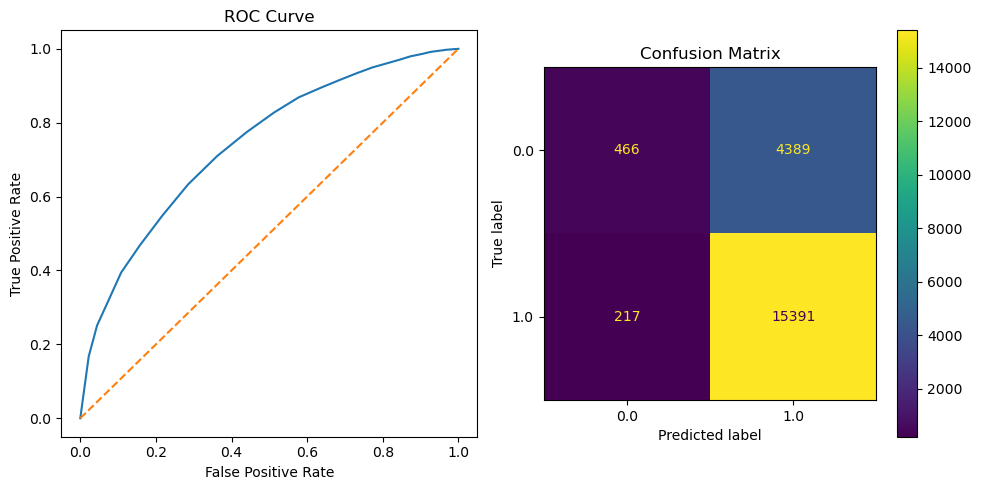

Test RMSE: 0.3980283669565726
Test MSE: 0.15842658090211603
Test MAE: 0.29299833846454576
Test Precision: 0.7781092012133468
Test Recall: 0.9860968733982574
Test F1 score: 0.8698428845936476
Test AUC: 0.7418959275683705
Test Confusion Matrix:
 {'TN': 466, 'FP': 4389, 'FN': 217, 'TP': 15391}
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3686
MAE:  0.2561


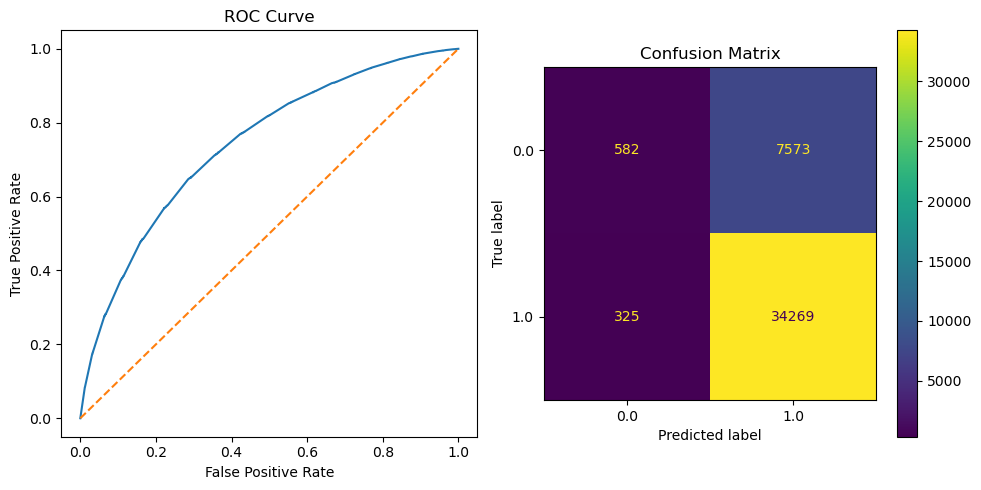

Test RMSE: 0.36864642376597995
Test MSE: 0.13590018575544646
Test MAE: 0.25614990807447363
Test Precision: 0.8190096075713398
Test Recall: 0.9906053072787189
Test F1 score: 0.8966717253650113
Test AUC: 0.7417944964602439
Test Confusion Matrix:
 {'TN': 582, 'FP': 7573, 'FN': 325, 'TP': 34269}
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3918
MAE:  0.2805


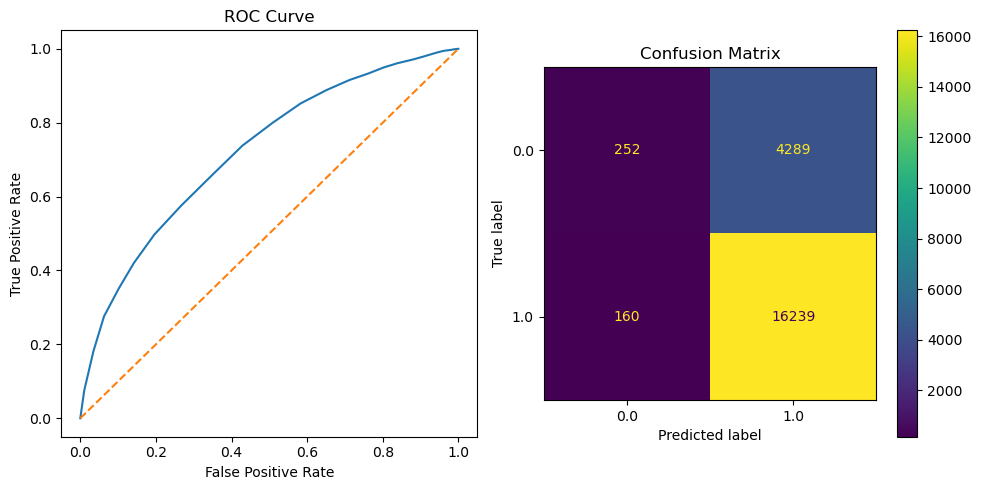

Test RMSE: 0.3918454930213516
Test MSE: 0.15354289040114608
Test MAE: 0.2805145654250239
Test Precision: 0.7910658612626656
Test Recall: 0.9902433075187511
Test F1 score: 0.8795190511008205
Test AUC: 0.7211984367645107
Test Confusion Matrix:
 {'TN': 252, 'FP': 4289, 'FN': 160, 'TP': 16239}
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3850
MAE:  0.2650


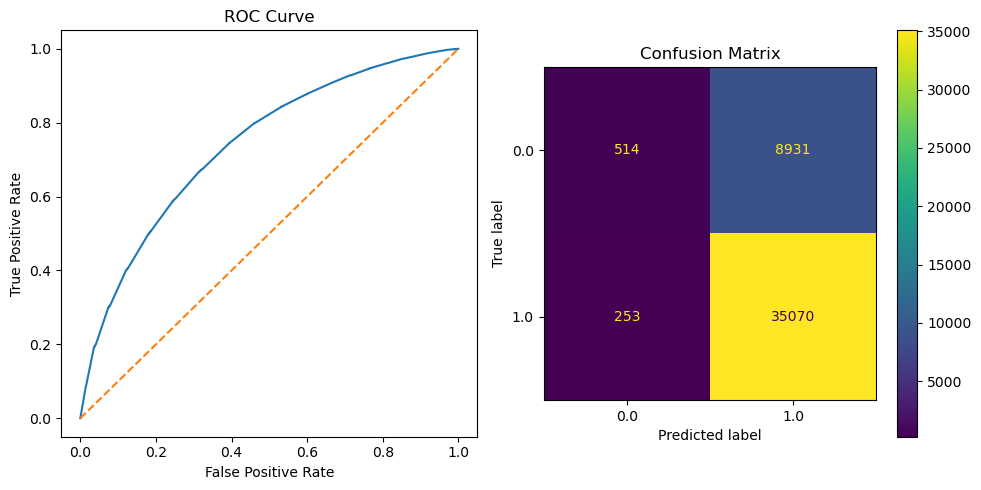

Test RMSE: 0.38500418133381287
Test MSE: 0.14822821964451946
Test MAE: 0.26501809039697544
Test Precision: 0.7970273402877207
Test Recall: 0.9928375279562891
Test F1 score: 0.8842216731380163
Test AUC: 0.7397213392426097
Test Confusion Matrix:
 {'TN': 514, 'FP': 8931, 'FN': 253, 'TP': 35070}


In [ ]:
def train_fit_test(train_recs, test_recs):
    
    # Reader and Dataset
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(train_recs[['user_id', 'app_id', 'is_recommended']], reader)

    # Convert 'date' to timestamp
    train_recs['timestamp'] = pd.to_datetime(train_recs['date']).astype(np.int64) / 10**9

    # Define model and parameters for GridSearchCV
    model = KNNBasic()

    param_grid = {
        'k': [5, 10],#, 15],
        'min_k': [1, 5],
        'sim_options': {
            'name': ['pearson'],#, 'pearson', 'pearson_baseline'],
            'user_based': [True],
        },
    }

    # model.fit(data)

    # # Fit model with training set and params that yeild the best rsme
    # best_model = gs.best_estimator['rmse']
    full_trainset = Dataset.load_from_df(train_recs[['user_id', 'app_id', 'is_recommended']], reader).build_full_trainset()
    model.fit(full_trainset)

    # Load the test dataset
    test_data = Dataset.load_from_df(test_recs[['user_id', 'app_id', 'is_recommended']], reader)
    testset = test_data.construct_testset(test_data.raw_ratings)

    # Make predictions
    predictions = model.test(testset)

    y_true = [pred.r_ui for pred in predictions]
    y_pred = [pred.est for pred in predictions]

    # Evaluate the model
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    # Round the predicted ratings to get binary labels
    y_pred_binary = np.round(y_pred)

    precision_test = precision_score(y_true, y_pred_binary)
    recall_test = recall_score(y_true, y_pred_binary)
    f1_test = f1_score(y_true, y_pred_binary)
    auc_test = roc_auc_score(y_true, y_pred)
    cm_vals = confusion_matrix(y_true, y_pred_binary)

    # Plot Confusion Matrix and ROC Curve
    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()
    cm_vals = {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp}
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Create a 1x2 grid of subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Plot ROC Curve on the first subplot (axes[0])
    axes[0].plot(fpr, tpr)
    axes[0].plot([0, 1], [0, 1], linestyle='--')
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("ROC Curve")

    # Plot Confusion Matrix on the second subplot (axes[1])
    from sklearn.metrics import ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred_binary, ax=axes[1])
    axes[1].set_title("Confusion Matrix")

    # Display the subplots
    plt.tight_layout()
    plt.show()

    print("Test RMSE:", rmse)
    print("Test MSE:", rmse ** 2)
    print("Test MAE:", mae)
    print("Test Precision:", precision_test)
    print("Test Recall:", recall_test)
    print("Test F1 score:", f1_test)
    print("Test AUC:", auc_test)
    print("Test Confusion Matrix:\n", cm_vals)
    

# Leave p-out fashion split with both filtered datasets
train_fit_test(train_p, test_p)
train_fit_test(train_pr, test_pr)

# Leave p-out / review stratified split with both filtered datasets
train_fit_test(train_ps, test_ps)
train_fit_test(train_psr, test_psr)

## Colaborative Filtering - Custom Model

In [ ]:
class CollaborativeFiltering:
    def __init__(self, sim='cosine', top_k=None, binary=True, user_based=True, bsl=True, content_boosted=False, alpha=0.5):
        self.similarity_metric = sim
        self.top_k = top_k
        self.binary = binary
        self.user_based = user_based
        self.bsl = bsl
        self.content_boosted = content_boosted
        self.alpha = alpha if self.content_boosted else 1 # else turn disable content boosting
        
    def convert_to_non_binary(self, data):
        data.loc[data['is_recommended'] == False, 'is_recommended'] = -1
        data.loc[data['is_recommended'] == True, 'is_recommended'] = 1
        return data

    def compute_baseline_estimates(self):
                   
        # Calculate the overall average game rating
        self.mu = self.sparse_interaction_matrix.sum() / self.sparse_interaction_matrix.count_nonzero()
        
        # Transpose the matrix for item-based filtering
        interaction_matrix = self.sparse_interaction_matrix
        ax_user = 1 if self.user_based else 0
        ax_item = 0 if self.user_based else 1
        
        # User bias: subtract the overall mean rating (mu) from the user's average rating and normalize the result by the user's number of rated items
        self.user_biases = interaction_matrix.sum(axis=ax_user).reshape(-1, 1) / (interaction_matrix.getnnz(axis=ax_user).reshape(-1, 1) + 1e-9) - self.mu
        
        # Item bias: subtract the overall mean rating (mu) from the item's average rating and normalize the result by the number of ratings the item has received
        self.item_biases = interaction_matrix.sum(axis=ax_item).reshape(-1, 1) / (interaction_matrix.getnnz(axis=ax_item).reshape(-1, 1) + 1e-9) - self.mu
                        
    def fit(self, train_recs):
        
        if not self.binary:
            train_recs = self.convert_to_non_binary(train_recs)
        
        # Create dictionaries to map user and item IDs to their respective indices
        self.user_id_to_idx = {user_id: idx for idx, user_id in enumerate(train_recs['user_id'].unique())}
        self.item_id_to_idx = {item_id: idx for idx, item_id in enumerate(train_recs['app_id'].unique())}
               
        # Find the number of unique users and items
        n_users = len(self.user_id_to_idx)# + 1 # Add 1 for unknown user
        n_items = len(self.item_id_to_idx)# + 1 # Add 1 for unknown item

        # Create a sparse user-item matrix
        rows = train_recs['user_id'].apply(lambda x: self.user_id_to_idx[x]).values
        cols = train_recs['app_id'].apply(lambda x: self.item_id_to_idx[x]).values
        ratings = train_recs['is_recommended'].astype(np.float32)
        
        if self.user_based == True:
            self.sparse_interaction_matrix = csr_matrix((ratings, (rows, cols)), shape=(n_users, n_items))
        else:
            self.sparse_interaction_matrix = csr_matrix((ratings, (cols, rows)), shape=(n_items, n_users))
        
        if self.bsl:
            self.compute_baseline_estimates()
        
        # Compute the similarity
        similarity_func = {
            'cosine': cosine_similarity,
            'euclidean': euclidean_distances,
            'manhattan': manhattan_distances,
        }
        self.entity_similarity = similarity_func[self.similarity_metric](self.sparse_interaction_matrix)

        # Fill the diagonal of the similarity matrix with zeros (remove self-similarity)
        np.fill_diagonal(self.entity_similarity, 0)
        
        if self.content_boosted:
            # Create content feature matrix
            unique_items = train_recs.drop_duplicates(subset=['app_id'])
            content_features = unique_items[['app_id', 'rating_deviation', 'user_avg_review']]
            content_features.set_index('app_id', inplace=True)

            # Normalize content features
            scaler = MinMaxScaler()
            content_features_scaled = scaler.fit_transform(content_features)

            # Compute the content similarity matrix
            self.content_similarity_matrix = cosine_similarity(content_features_scaled)
  
    def predict(self, input_recs):
        
        if not self.binary:
            input_recs = self.convert_to_non_binary(input_recs)
        
        n_users = len(self.user_id_to_idx)#+1
        n_items = len(self.item_id_to_idx)#+1
#         print(f"n_users: {n_users}, n_items: {n_items}")

        # Predict the ratings
        predicted_ratings = np.zeros((n_users, n_items)) if self.user_based else np.zeros((n_items, n_users))
#         print(f"predicted_ratings shape: {predicted_ratings.shape}")
        
        # Determine the loop range based on user_based
        loop_range = n_users if self.user_based else n_items
    
        for idx in range(loop_range):
            
            content_similarity = np.zeros(n_items if self.user_based else n_users)#content_similarity = 0
            if self.content_boosted:
                if self.user_based:
                    # Calculate the weighted sum of content similarity
                    interactions = self.sparse_interaction_matrix[idx].nonzero()[1]
                    if interactions.size > 0:
                        content_similarity = self.content_similarity_matrix[interactions].mean(axis=0)
                else:
                    content_similarity = self.content_similarity_matrix[idx]
                    user_ratings = self.sparse_interaction_matrix.T.toarray()
                    content_similarity_vector = np.dot(user_ratings, content_similarity)
                
            # If top_k is not None, select the top-k most similar users/items
            if self.top_k is not None:
                top_k_similarities = np.argsort(self.entity_similarity[idx])[-self.top_k:]
                similarity_values = self.entity_similarity[idx, top_k_similarities]
                neighborhood = self.sparse_interaction_matrix[top_k_similarities, :].toarray()
            else:
                similarity_values = self.entity_similarity[idx]
                neighborhood = self.sparse_interaction_matrix.toarray(idx)
            
            # Calculate the weighted sum of other users' ratings multiplied by similarity
            weighted_sum = np.dot(similarity_values, neighborhood)
                
            # Combine the collaborative filtering and content-based filtering results
            if self.content_boosted:
                if not self.user_based:
                    user_ratings = self.sparse_interaction_matrix.T.toarray()
                    content_similarity_vector = np.dot(user_ratings, content_similarity)
                    combined = self.alpha * weighted_sum + (1 - self.alpha) * content_similarity_vector
                else:
                    combined = self.alpha * weighted_sum + (1 - self.alpha) * content_similarity
            else:
                combined = weighted_sum

            # Normalize by the sum of similarities
            sim_sum = np.sum(np.abs(self.entity_similarity[idx]))

            # Make predictions (add a small constant to the denominator to prevent division by zero)
            epsilon = 1e-9
            prediction = combined / (sim_sum + epsilon)
            
            if not self.bsl:
                predicted_ratings[idx] = prediction
            else:
                if self.user_based:
                    predicted_ratings[idx] = prediction + self.mu + self.user_biases[idx] + self.item_biases.ravel()
                else:
                    predicted_ratings[idx] = prediction + self.mu + self.user_biases.ravel() + self.item_biases[idx]
            
        # Transpose the matrix for item-based filtering
        if not self.user_based:
            predicted_ratings = predicted_ratings.T
        
        # Create a DataFrame for predicted ratings
        user_ids = np.array(list(self.user_id_to_idx.keys()))
        item_ids = np.array(list(self.item_id_to_idx.keys()))
        
        predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_ids, columns=item_ids)

#         if self.binary:
#             return predicted_ratings_df.loc[input_recs['user_id'].unique(), input_recs['app_id'].unique()]
#         else:
#             return predicted_ratings_df
        return predicted_ratings_df
    
    # Prepare the data for evaluation
    def evaluate(self, test_recs):
        self.predicted_ratings_test_df = self.predict(test_recs)
        predicted_ratings_test_long = self.predicted_ratings_test_df.stack().reset_index()
        predicted_ratings_test_long.columns = ['user_id', 'app_id', 'predicted_rating']
        self.results_test_df = pd.merge(test_recs, predicted_ratings_test_long, on=['user_id', 'app_id'])       
        return self.results_test_df, predicted_ratings_test_long
    
    # Evaluate
    def performance_metrics(self, show_plots=True):
        y_true = self.results_test_df['is_recommended']
        y_pred = self.results_test_df['predicted_rating']
        
        # Min-max scaling
        min_y_pred = np.min(y_pred)
        max_y_pred = np.max(y_pred)
        y_pred = (y_pred - min_y_pred) / (max_y_pred - min_y_pred)

        # Map 1s/-1s back to True/False
        if not self.binary:
            y_true = np.where(y_true == 1, True, False)
            
        # Round the predicted ratings to get binary labels  
        y_pred_binary = np.round(y_pred)

        # Calculate the RMSE, MSE, and MAE
        self.rmse_test = np.sqrt(mean_squared_error(y_true, y_pred))
        self.mse_test = mean_squared_error(y_true, y_pred)
        self.mae_test = mean_absolute_error(y_true, y_pred)
        
        # Calculate Precision, Recall, F1 score and AUC
        precision_test = precision_score(y_true, y_pred_binary)
        recall_test = recall_score(y_true, y_pred_binary)
        f1_test = f1_score(y_true, y_pred_binary)
        auc_test = roc_auc_score(y_true, y_pred)

        # Plot Confusion Matrix and ROC Curve
        cm = confusion_matrix(y_true, y_pred_binary)
        tn, fp, fn, tp = cm.ravel()
        cm_vals = {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp}
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)        
        
        if show_plots:
            # Create a 1x2 grid of subplots
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        
            # Plot ROC Curve on the first subplot (axes[0])        
            axes[0].plot(fpr, tpr)
            axes[0].plot([0, 1], [0, 1], linestyle='--')
            axes[0].set_xlabel("False Positive Rate")
            axes[0].set_ylabel("True Positive Rate")
            axes[0].set_title("ROC Curve")

            # Plot Confusion Matrix on the second subplot (axes[1])
            from sklearn.metrics import ConfusionMatrixDisplay
            ConfusionMatrixDisplay.from_predictions(y_true, y_pred_binary, ax=axes[1])
            axes[1].set_title("Confusion Matrix")

            # Display the subplots
            plt.tight_layout()
            plt.show()

        self.performance_metrics = {
            'rmse': self.rmse_test,
            'mse': self.mse_test,
            'mae': self.mae_test,
            'precision': precision_test,
            'recall': recall_test,
            'f1': f1_test,
            'auc': auc_test,
            'cm': cm_vals,
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds,
        }
        return self.performance_metrics
    
    def print_metrics(self):
        print("Test RMSE:", self.performance_metrics['rmse'])
        print("Test MSE:", self.performance_metrics['mse'])
        print("Test MAE:", self.performance_metrics['mae'])
        print("Test Precision:", self.performance_metrics['precision'])
        print("Test Recall:", self.performance_metrics['recall'])
        print("Test F1 score:", self.performance_metrics['f1'])
        print("Test AUC:", self.performance_metrics['auc'])
        print("Test Confusion Matrix:\n", self.performance_metrics['cm'])
    
# Add features to train and test sets:
def extract_features(df_recs, df_users, df_games):
    # Merge the dataframes
    merged_data = pd.merge(df_recs, df_users, on='user_id')
    merged_data = pd.merge(merged_data, df_games, on='app_id')

    # Define the numerical mapping for rating categories
    rating_mapping = {
        'Overwhelmingly Positive': 1,
        'Very Positive': 0.75,
        'Mostly Positive': 0.5,
        'Positive': 0.25,
        'Mixed': 0,
        'Negative': -0.25,
        'Mostly Negative': -0.5,
        'Very Negative': -0.75,
        'Overwhelmingly Negative': -1
    }

    # Apply the mapping to the 'rating' column
    merged_data['rating_numeric'] = merged_data['rating'].map(rating_mapping)

    # User-based features
    user_features = merged_data.groupby('user_id').agg(
        user_avg_review=('is_recommended', 'mean')  # Average of is_recommended values for each user's reviews
    )
    merged_data = merged_data.merge(user_features, on='user_id', how='left')

    # Interaction-based features
    merged_data['rating_deviation'] = merged_data['is_recommended'].astype(int) - merged_data['rating_numeric']  # Difference between the boolean recommendation and the numerical rating of the game

    return merged_data

In [ ]:
def preprocess_steam_data(steam_data, random_dataset, verbose=False, plot=False):
    if random_dataset:
        thresh = [1, 1, 10, 0.1]
    else:
        thresh = [60000, 100, 5, 1]
    steam_data_filt = fn.preprocess_data(steam_data, thresh=thresh, verbose=verbose, plot=plot)
    return steam_data_filt

def unpack_steam_data(steam_data_filt):
    df_games_filt, df_users_filt, df_recs_filt = fn.unpack_dict(steam_data_filt)
    return df_games_filt, df_users_filt, df_recs_filt

def estimate_memory(steam_data_filt, verbose=False):
    fn.estimate_memory_consumption(steam_data_filt, test_size=0.2, rating_metric='is_recommended', verbose=verbose)

def fit_and_evaluate_model(train_recs_fx, test_recs_fx):
    cf = CollaborativeFiltering(sim='cosine', 
                                top_k=7, 
                                binary=False, 
                                user_based=True, 
                                bsl=True,
                                content_boosted=True, 
                                alpha=.9)
    cf.fit(train_recs_fx)
    results_test_df = cf.evaluate(test_recs_fx)
    metrics = cf.performance_metrics(show_plots=False)
    return metrics

def evaluate_model(train_data, validation_data, params):
    cf = CollaborativeFiltering(**params)
    cf.fit(extract_features(train_data, df_users_filt, df_games_filt))
    predictions = cf.evaluate(extract_features(validation_data, df_users_filt, df_games_filt))
    return cf, predictions

def identify_missing_info(train, test, col='user_id'):
    # Find 'user_id' in test_recs that are not in train_recs
    missing_info = test[~test[col].isin(train[col])]

    # Print 'user_id' that are in test_recs but not in train_recs
    if len(missing_info) > 0:
        print(f"The following '{col}'s are in 'test_recs' but not in 'train_recs':")
        print(missing_info[col].unique())
        
    return missing_info

def remove_missing_users(train, test):
    return test[test['user_id'].isin(train['user_id'])]

def train_test_cf_custom(train_recs, test_recs, steam_data_filt, trial):
    
    # User-based vs Item-based
    if trial==1:
        param_grid = {
            'sim': ['cosine'],
            'top_k': [10],
            'binary': [True],
            'user_based': [True, False],
            'bsl': [False],
            'content_boosted': [False],
            'alpha': [1]
        }
        
    # Binary vs Non-binary
    elif trial == 2:
        param_grid = {
            'sim': ['cosine'],
            'top_k': [10],
            'binary': [True, False],
            'user_based': [False],
            'bsl': [False],
            'content_boosted': [False],
            'alpha': [1]
        }
    
    # Baseline vs No Baseline
    elif trial == 3:
        param_grid = {
            'sim': ['cosine'],
            'top_k': [10],
            'binary': [False],
            'user_based': [False],
            'bsl': [False, True],
            'content_boosted': [False],
            'alpha': [1]
        }
    
    # Content Boosted vs Not Content Boosted
    elif trial == 4:
        param_grid = {
            'sim': ['cosine'],
            'top_k': [10],
            'binary': [False],
            'user_based': [False],
            'bsl': [True],
            'content_boosted': [False, True],
            'alpha': [.9]
        }
    
    # Test all combinations
    else:
        param_grid = {
            'sim': ['cosine'],
            'top_k': [5, 7, 10],
            'binary': [True, False],
            'user_based': [True, False],
            'bsl': [True, False],
            'content_boosted': [True, False],
            'alpha': [.7, .9]
        }

    # Main code execution
    df_games_filt, df_users_filt, df_recs_filt = unpack_steam_data(steam_data_filt)

    train_recs_fx = extract_features(train_recs, df_users_filt, df_games_filt)
    test_recs_fx = extract_features(test_recs, df_users_filt, df_games_filt)

    best_mse = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        mse_list = []

        # Remove 'user_id's in test_recs that are not in train_recs
        missing_users = identify_missing_info(train_recs, test_recs, 'user_id')
        missing_items = identify_missing_info(train_recs, test_recs, 'app_id')
        validation_data = remove_missing_users(train_recs, test_recs)

        print(params)
        cf, predictions = evaluate_model(train_recs, test_recs, params)
        
        if trial > 0:
            metrics = cf.performance_metrics(show_plots=True)
            cf.print_metrics()
        else:
            metrics = cf.performance_metrics(show_plots=False)
            mse_list.append(metrics['mse'])
            avg_mse = np.mean(mse_list)
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params = params
    
    if trial == 0:
        # Fit the model with the best parameters
        cf = CollaborativeFiltering(**best_params)
        cf.fit(train_recs_fx)

        # Evaluate the model
        results_test_df = cf.evaluate(test_recs_fx)
        metrics = cf.performance_metrics(show_plots=True)

        # Print performance metrics
        print(best_params)
        cf.print_metrics()
        
        return metrics, results_test_df
    return

## Trial 1: User-based vs Item-based

{'alpha': 1, 'binary': True, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': True}


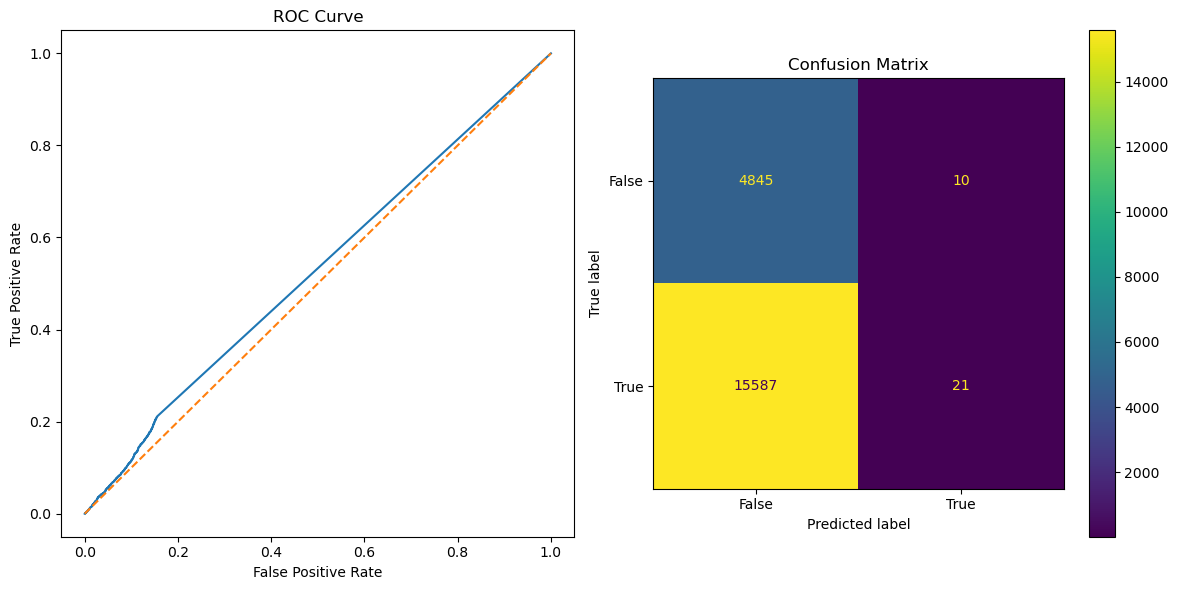

Test RMSE: 0.8489216049739288
Test MSE: 0.7206678913915111
Test MAE: 0.7446794035983341
Test Precision: 0.6774193548387096
Test Recall: 0.001345463864684777
Test F1 score: 0.002685593708037598
Test AUC: 0.5261183100271798
Test Confusion Matrix:
 {'TN': 4845, 'FP': 10, 'FN': 15587, 'TP': 21}
{'alpha': 1, 'binary': True, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': False}


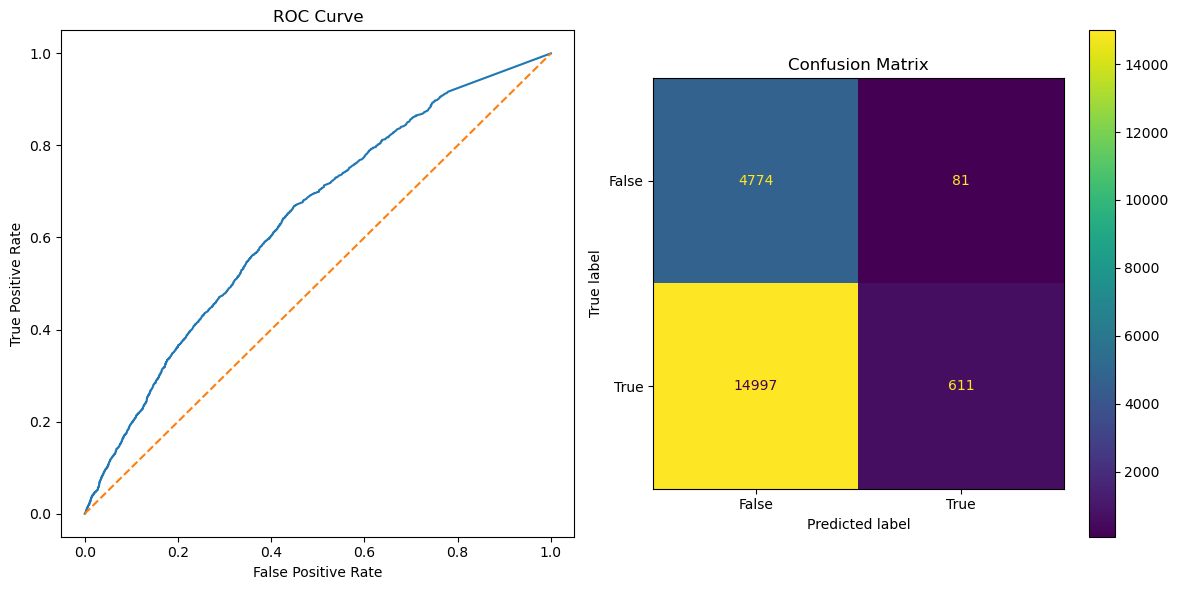

Test RMSE: 0.6850139341393975
Test MSE: 0.4692440899651347
Test MAE: 0.6216409980093507
Test Precision: 0.8829479768786127
Test Recall: 0.0391465914915428
Test F1 score: 0.07496932515337423
Test AUC: 0.6383266641892166
Test Confusion Matrix:
 {'TN': 4774, 'FP': 81, 'FN': 14997, 'TP': 611}


In [ ]:
train_test_cf_custom(train_p, test_p, steam_data_filt, trial=1)

## Trial 2: Binary vs Non-Binary
This trial uses best model from previous trial to show any improvements

{'alpha': 1, 'binary': True, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': False}


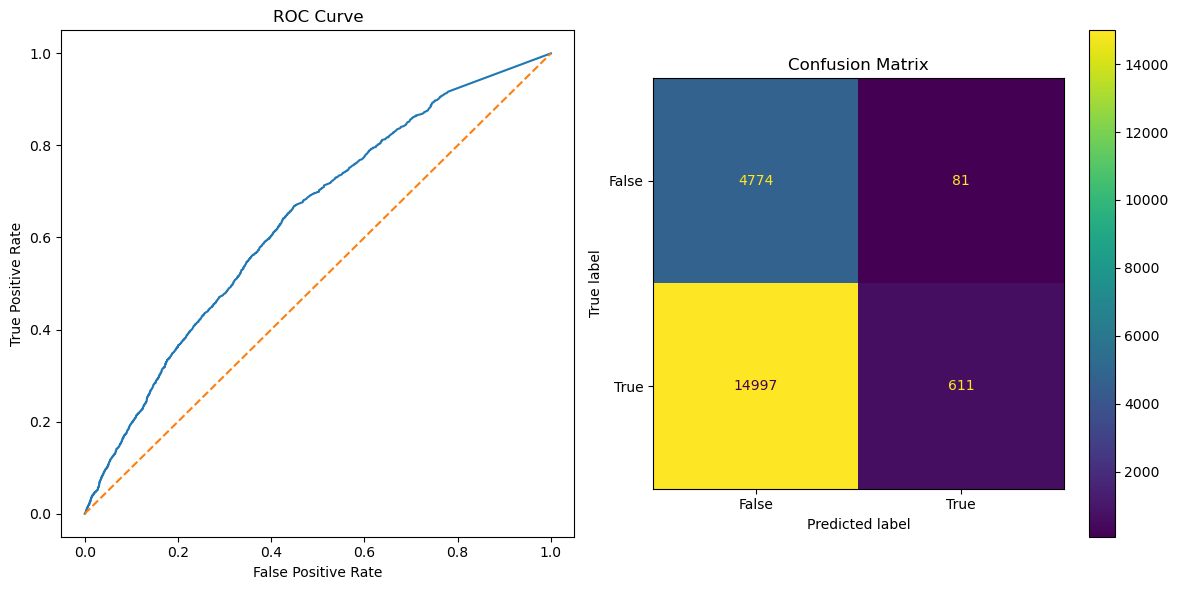

Test RMSE: 0.6850139341393975
Test MSE: 0.4692440899651347
Test MAE: 0.6216409980093507
Test Precision: 0.8829479768786127
Test Recall: 0.0391465914915428
Test F1 score: 0.07496932515337423
Test AUC: 0.6383266641892166
Test Confusion Matrix:
 {'TN': 4774, 'FP': 81, 'FN': 14997, 'TP': 611}
{'alpha': 1, 'binary': False, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': False}


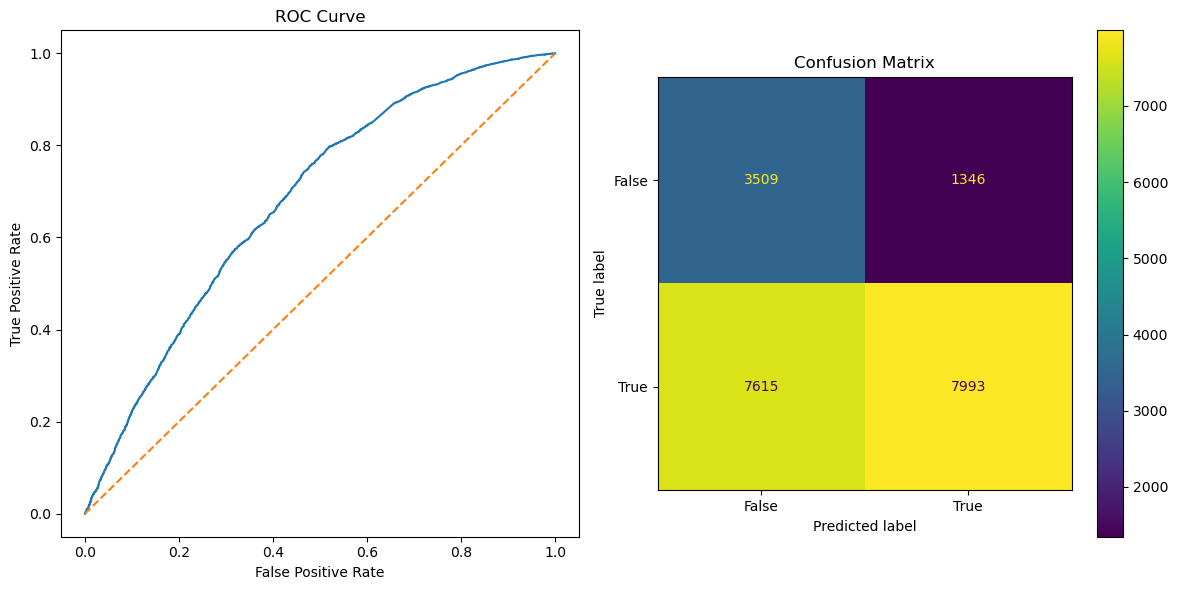

Test RMSE: 0.49882645773159334
Test MSE: 0.24882783493304908
Test MAE: 0.48462734959445225
Test Precision: 0.855873219830817
Test Recall: 0.512109174782163
Test F1 score: 0.640798492804746
Test AUC: 0.6799678239419854
Test Confusion Matrix:
 {'TN': 3509, 'FP': 1346, 'FN': 7615, 'TP': 7993}


In [ ]:
train_test_cf_custom(train_p, test_p, steam_data_filt, trial=2)

## Trial 3: No Baseline vs Baseline
This trial uses best model from previous trial to show any improvements

{'alpha': 1, 'binary': False, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': False}


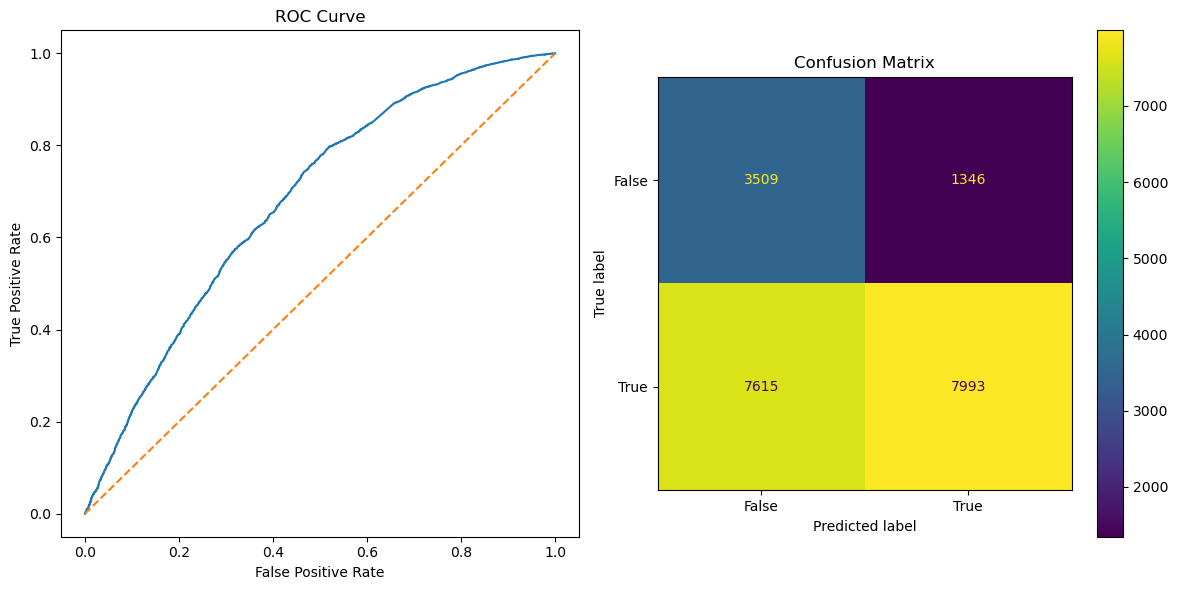

Test RMSE: 0.49882645773159334
Test MSE: 0.24882783493304908
Test MAE: 0.48462734959445225
Test Precision: 0.855873219830817
Test Recall: 0.512109174782163
Test F1 score: 0.640798492804746
Test AUC: 0.6799678239419854
Test Confusion Matrix:
 {'TN': 3509, 'FP': 1346, 'FN': 7615, 'TP': 7993}
{'alpha': 1, 'binary': False, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': False}


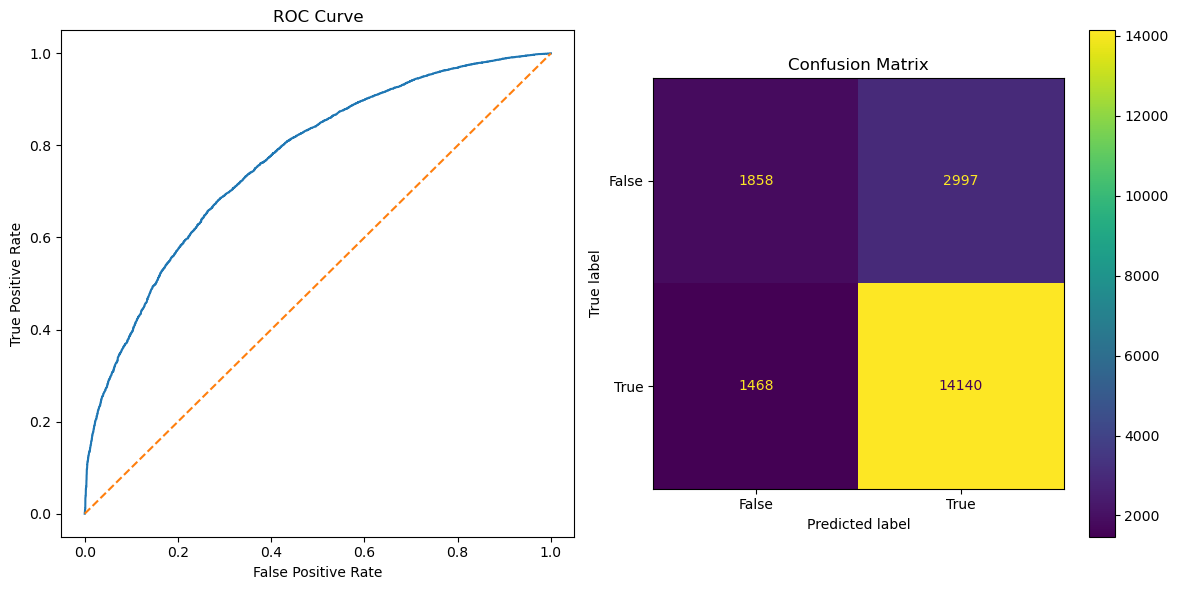

Test RMSE: 0.39580969782437075
Test MSE: 0.15666531689181967
Test MAE: 0.3457446710105485
Test Precision: 0.8251152477096341
Test Recall: 0.9059456688877499
Test F1 score: 0.8636433043212703
Test AUC: 0.7671699558862577
Test Confusion Matrix:
 {'TN': 1858, 'FP': 2997, 'FN': 1468, 'TP': 14140}


In [ ]:
train_test_cf_custom(train_p, test_p, steam_data_filt, trial=3)

## Trial 4: Non Content Boosted vs Content Boosted
This trial uses best model from previous trial to show any improvements

{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': False}


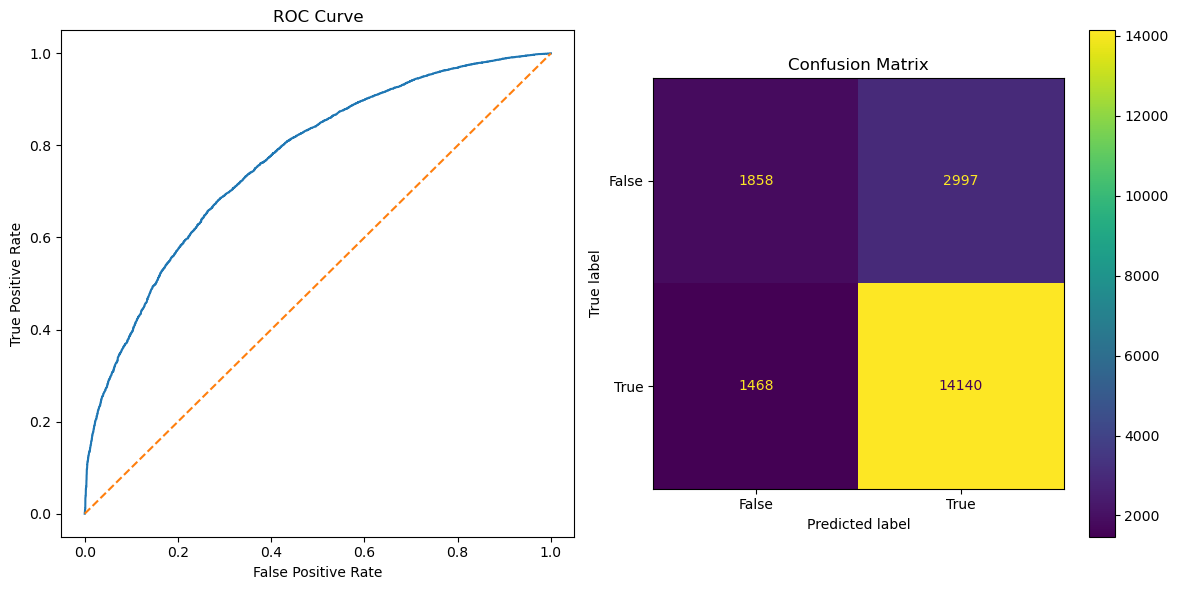

Test RMSE: 0.39580969782437075
Test MSE: 0.15666531689181967
Test MAE: 0.3457446710105485
Test Precision: 0.8251152477096341
Test Recall: 0.9059456688877499
Test F1 score: 0.8636433043212703
Test AUC: 0.7671699558862577
Test Confusion Matrix:
 {'TN': 1858, 'FP': 2997, 'FN': 1468, 'TP': 14140}
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': False}


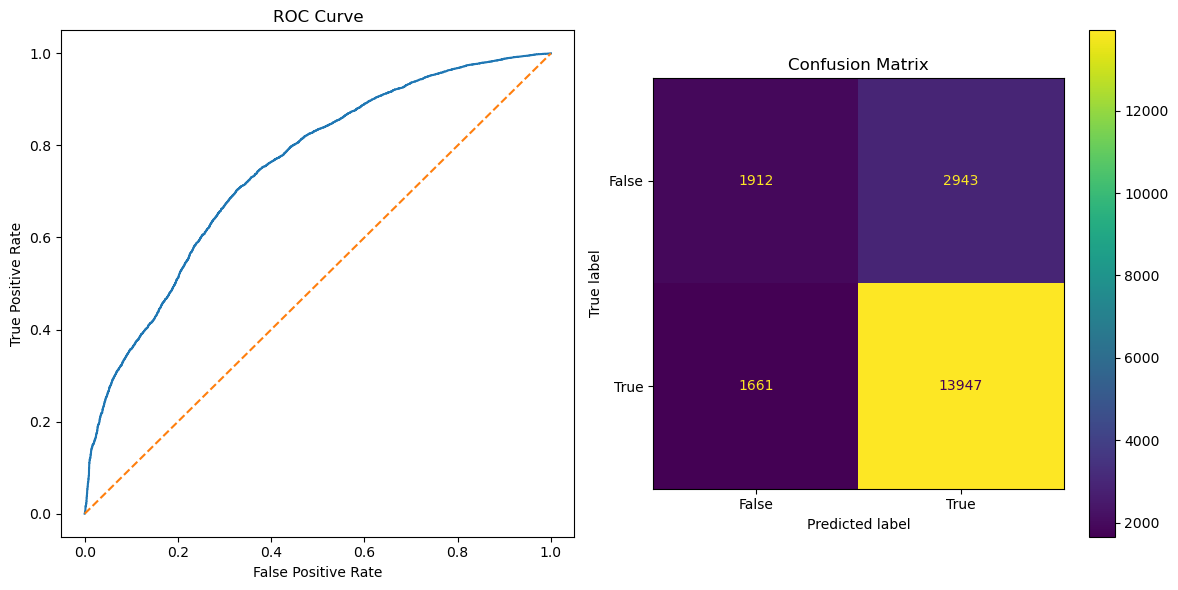

Test RMSE: 0.4177382989054674
Test MSE: 0.1745052863724336
Test MAE: 0.39310317923862537
Test Precision: 0.8257548845470692
Test Recall: 0.8935802152742184
Test F1 score: 0.8583297433688226
Test AUC: 0.7491854569285286
Test Confusion Matrix:
 {'TN': 1912, 'FP': 2943, 'FN': 1661, 'TP': 13947}


In [ ]:
train_test_cf_custom(train_p, test_p, steam_data_filt, trial=4)

## Trial 5: Test All Combinations
This trial uses the heavily filtered data + leave-p-out split method

{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': True}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': False}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': True}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': False}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 5, 'user_based': True}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 5, 'user_based': False}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'con

{'alpha': 0.9, 'binary': True, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
{'alpha': 0.9, 'binary': True, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
{'alpha': 0.9, 'binary': True, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': False}
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': True}
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': False}
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': True}
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
{'alpha': 0.9, 'binary': False, 'bsl':

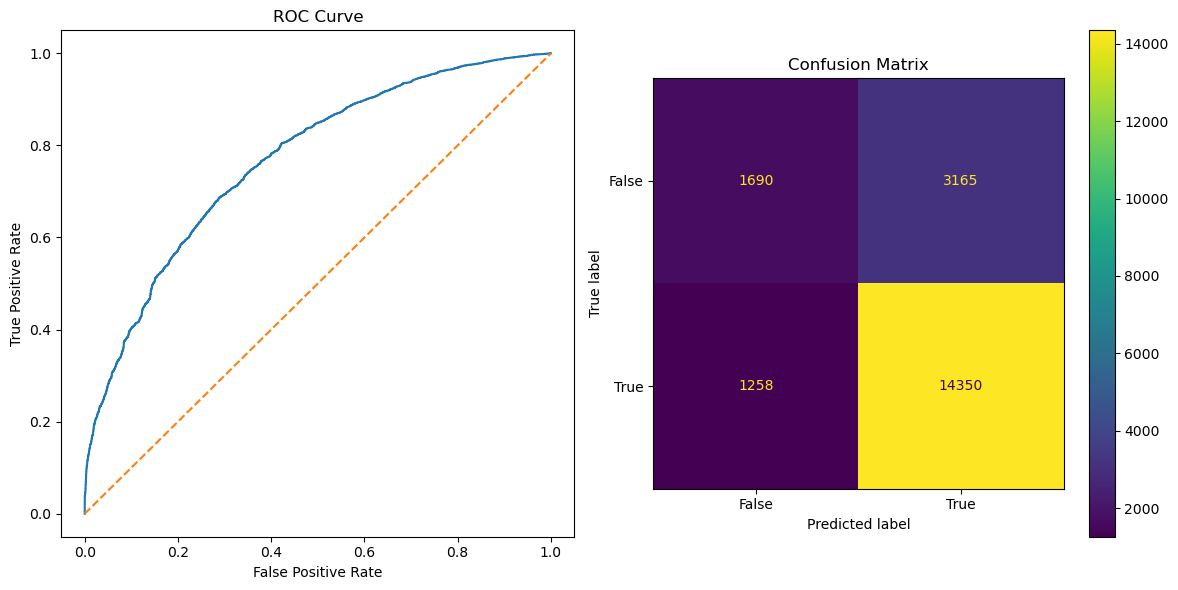

{'alpha': 0.7, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': True}
Test RMSE: 0.3891125597573538
Test MSE: 0.15140858416092026
Test MAE: 0.3177706223519138
Test Precision: 0.8192977447901798
Test Recall: 0.9194003075345977
Test F1 score: 0.8664674093530176
Test AUC: 0.767576735846995
Test Confusion Matrix:
 {'TN': 1690, 'FP': 3165, 'FN': 1258, 'TP': 14350}


In [ ]:
results_5 = train_test_cf_custom(train_p, test_p, steam_data_filt, trial=0)

## Trial 6: Test All Combinations
This trial uses the heavily filtered data + leave-p-out / review stratified split method

{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': True}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': False}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': True}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': False}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 5, 'user_based': True}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 5, 'user_based': False}
{'alpha': 0.7, 'binary': True, 'bsl': True, 'con

{'alpha': 0.9, 'binary': True, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
{'alpha': 0.9, 'binary': True, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
{'alpha': 0.9, 'binary': True, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': False}
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': True}
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': False}
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': True}
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
{'alpha': 0.9, 'binary': False, 'bsl':

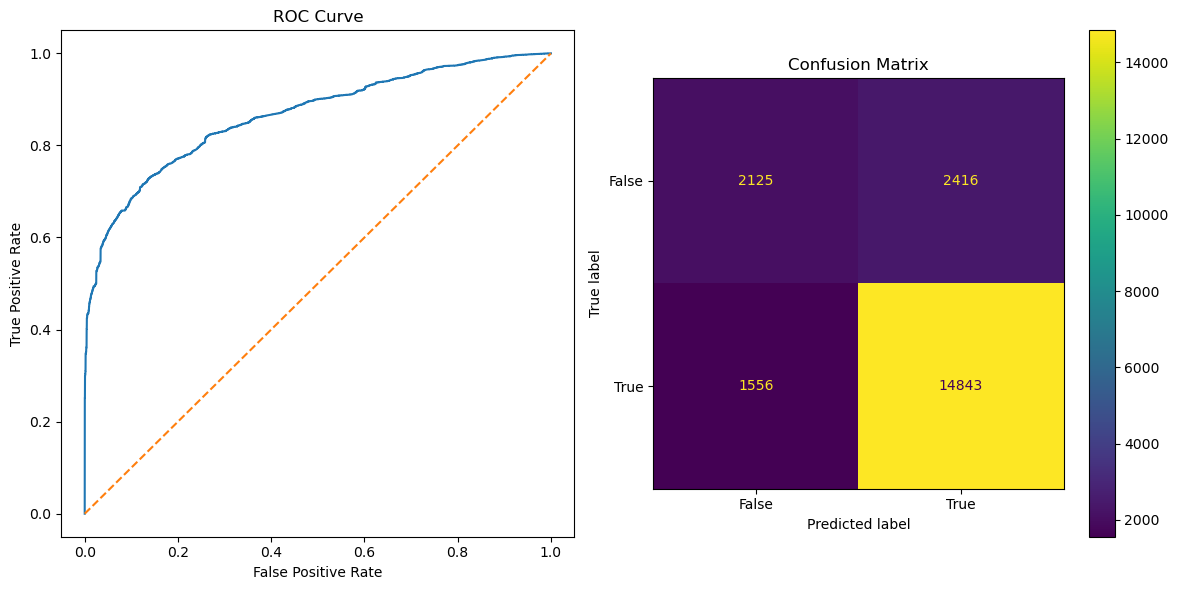

{'alpha': 0.7, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
Test RMSE: 0.3614396846449433
Test MSE: 0.13063864563623606
Test MAE: 0.3053457405904452
Test Precision: 0.8600150646039747
Test Recall: 0.9051161656198549
Test F1 score: 0.8819894230197873
Test AUC: 0.8646735365387636
Test Confusion Matrix:
 {'TN': 2125, 'FP': 2416, 'FN': 1556, 'TP': 14843}


In [ ]:
results_6 = train_test_cf_custom(train_ps, test_ps, steam_data_filt, trial=0)

## Trial 7: Test All Combinations
This trial uses the lightly filtered and randomly sampled data + leave-p-out split method

The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.7, '

The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.7, 'binary': False, 'bsl': False, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.7, 'binary': False, 'bsl': False, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.7, 'binary': False, 'bsl': False, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.7, 'binary': False, 'bsl': False, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha

The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 5, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[1502990  450540     620 2111850]
{'alpha':

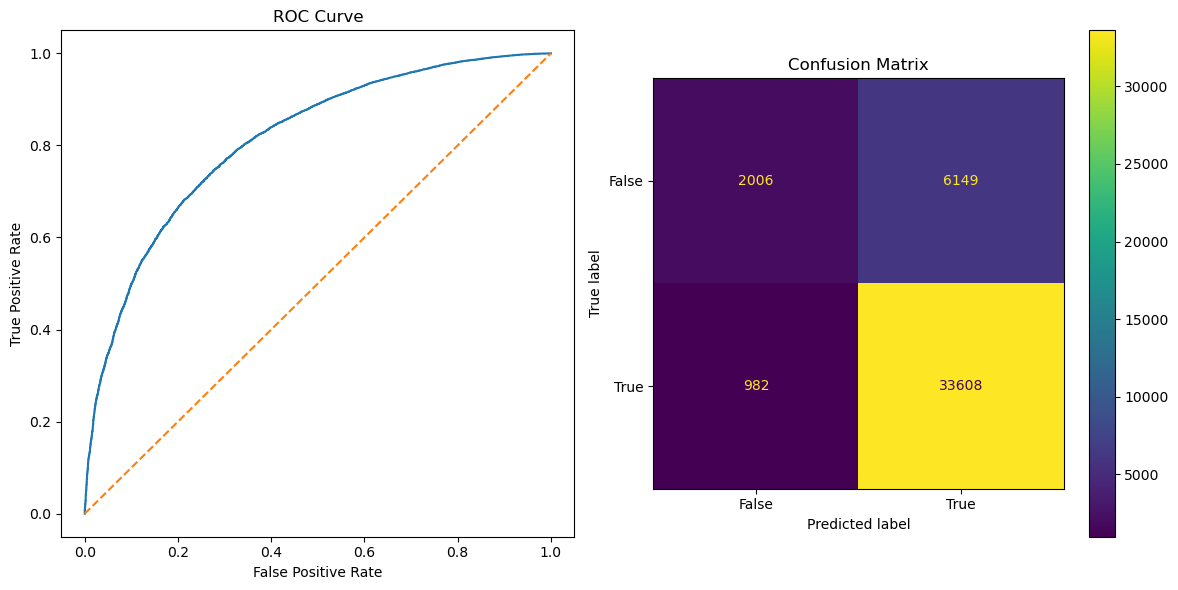

{'alpha': 0.7, 'binary': False, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': True}
Test RMSE: 0.35198426664668386
Test MSE: 0.12389292396680386
Test MAE: 0.2813298059601004
Test Precision: 0.8453354126317378
Test Recall: 0.9716102919919052
Test F1 score: 0.9040848991889383
Test AUC: 0.8113479351442642
Test Confusion Matrix:
 {'TN': 2006, 'FP': 6149, 'FN': 982, 'TP': 33608}


In [ ]:
results_7 = train_test_cf_custom(train_pr, test_pr, steam_data_filt_rnd, trial=0)

## Trial 8: Test All Combinations
This trial uses the lightly filtered and randomly sampled data + leave-p-out / review stratified split method

The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 5, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.7, 'binary': True, 'bsl': True, 'content_boo

The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.7, 'binary': False, 'bsl': False, 'content_boosted': True, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.7, 'binary': False, 'bsl': False, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.7, 'binary': False, 'bsl': False, 'content_boosted': True, 'sim': 'cosine', 'top_k': 10, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.7, 'binary': False, 'bsl': False, 'content_boosted': False, 'sim': 'cosine', 'top_k': 5, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.7, 'binary': False, 'bsl': False,

The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 5, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 7, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 7, 'user_based': False}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.9, 'binary': False, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
The following 'app_id's are in 'test_recs' but not in 'train_recs':
[ 450540  268910 1061910]
{'alpha': 0.9, 'binary': False, 'bsl': True, 'c

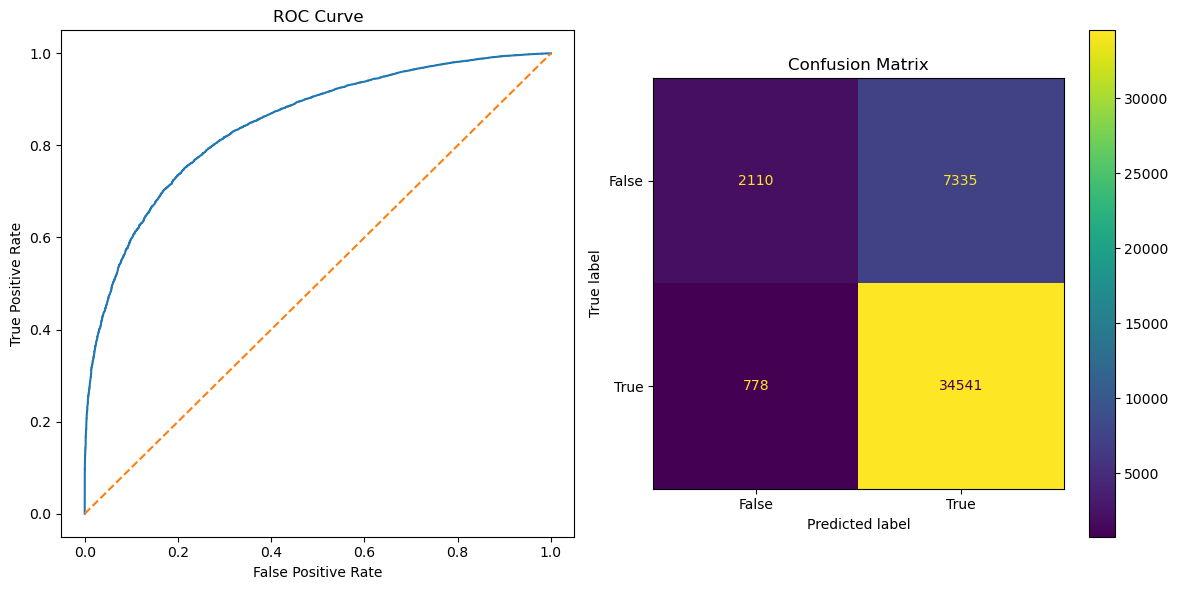

{'alpha': 0.7, 'binary': False, 'bsl': True, 'content_boosted': False, 'sim': 'cosine', 'top_k': 10, 'user_based': True}
Test RMSE: 0.35443980343240045
Test MSE: 0.12562757425719867
Test MAE: 0.28297014457277947
Test Precision: 0.8248400038208042
Test Recall: 0.9779721962682976
Test F1 score: 0.894902519593238
Test AUC: 0.8465762020694063
Test Confusion Matrix:
 {'TN': 2110, 'FP': 7335, 'FN': 778, 'TP': 34541}


In [ ]:
results_8 = train_test_cf_custom(train_psr, test_psr, steam_data_filt_rnd, trial=0)

In [ ]:
# results_8

In [ ]:
actual_ratings = results_8[0]['is_recommended']
predicted_test_ratings = results_8[0]['predicted_rating']

# Convert back to binary ratings
actual_ratings = np.where(actual_ratings == 1, True, False)

# Min-max scale predicted values between 0 and 1
min_y_pred = np.min(predicted_test_ratings)
max_y_pred = np.max(predicted_test_ratings)
predicted_test_ratings = (predicted_test_ratings - min_y_pred) / (max_y_pred - min_y_pred)

# Round the predicted ratings to get binary labels  
# predicted_test_ratings = np.round(predicted_test_ratings)

### Error distribution plot - Absolute Error
A histogram to show the distribution of absolute errors between actual and predicted ratings.

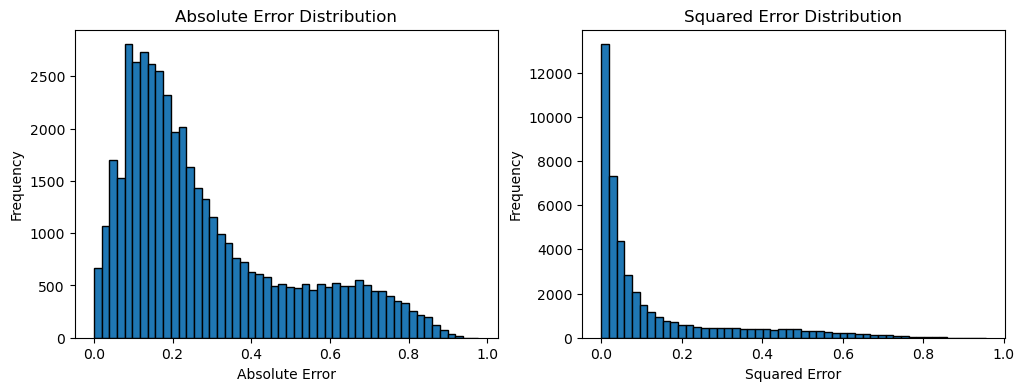

In [ ]:
# Calculate the errors
absolute_errors = np.abs(actual_ratings - predicted_test_ratings)
squared_errors = (actual_ratings - predicted_test_ratings) ** 2

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the absolute error distribution on the left
axes[0].hist(absolute_errors, bins=50, edgecolor='black')
axes[0].set_xlabel('Absolute Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Absolute Error Distribution')

# Plot the squared error distribution on the right
axes[1].hist(squared_errors, bins=50, edgecolor='black')
axes[1].set_xlabel('Squared Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Squared Error Distribution')

# Display the plots
plt.show()

In [ ]:
# Save all fuctions into .py file for other notebooks to access
util.save_funcs(NOTEBOOK_PATH, FUNCTIONS_DIR)